In [55]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *

import torchvision
import geffnet # efficient/ mobile net
from PIL import Image as PilImage
import cv2

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'

In [82]:
class BaseFilter():
    def __init__(self, learn: Learner, map_to_orig: bool = False):
        self.learn = learn
        self.norm, self.denorm = normalize_funcs(*imagenet_stats)
        self.render_base = 16
        self.map_to_orig = map_to_orig


    def _scale_to_square(self, orig: PilImage, targ: int) -> PilImage:
        # a simple stretch to fit a square really makes a big difference in rendering quality/consistency.
        # I've tried padding to the square as well (reflect, symetric, constant, etc).  Not as good!
        targ_sz = (targ, targ) 
        return orig.resize(targ_sz, resample=PIL.Image.BILINEAR)

    def _get_model_ready_image(self, orig: PilImage, sz: int) -> PilImage:
        result = self._scale_to_square(orig, sz)
        return result

    def _model_process(self, orig: PilImage, sz: int) -> PilImage:
        model_image = self._get_model_ready_image(orig, sz)
        x = pil2tensor(model_image, np.float32)
        x.div_(255)
        x, y = self.norm((x, x), do_x=True)
        result = self.learn.pred_batch(
            ds_type=DatasetType.Valid, batch=(x[None].cuda(), y[None]), reconstruct=True
        )
        out = result[0]
        out = self.denorm(out.px, do_x=False)
        out = image2np(out * 255).astype(np.uint8)
        return PilImage.fromarray(out)

    def _unsquare(self, image: PilImage, orig: PilImage) -> PilImage:
        targ_sz = orig.size
        image = image.resize(targ_sz, resample=PIL.Image.BILINEAR)
        return image
    
    def _post_process(self, raw_color: PilImage, orig: PilImage) -> PilImage:
        raw_color = self._unsquare(raw_color, orig)
        color_np = np.asarray(raw_color)
        orig_np = np.asarray(orig)
        color_yuv = cv2.cvtColor(color_np, cv2.COLOR_BGR2YUV)
        # do a black and white transform first to get better luminance values
        orig_yuv = cv2.cvtColor(orig_np, cv2.COLOR_BGR2YUV)
        hires = np.copy(orig_yuv)
        hires[:, :, 1:3] = color_yuv[:, :, 1:3]
        final = cv2.cvtColor(hires, cv2.COLOR_YUV2BGR)
        final = PilImage.fromarray(color_np)
        return final
    
    def filter(
        self, orig_image: PilImage, filtered_image: PilImage, render_factor: int
    ) -> PilImage:
        render_sz = orig_image.size[0] * 2
        print(render_sz)
        model_image = self._model_process(orig=filtered_image, sz=render_sz)

        if self.map_to_orig:
            return self._post_process(model_image, orig_image)
        else:
            return self._post_process(model_image, filtered_image)

In [63]:
def get_dummy_databunch() -> ImageDataBunch:
    path = Path('./dummy/')
    return get_colorize_data(
        sz=1, bs=1, crappy_path=path, good_path=path, keep_pct=0.001
    )

In [38]:
model = geffnet.mobilenetv3_rw
loss_func = lpips_loss()

bs=1
sz=512

data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=2)

learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_wideNf2_superRes_mobilenetV3_GAN_0"
learn_gen.load(weights, with_opt=False)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2)
y: ImageList
Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2)
y: ImageList
Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2),Image (3, 2, 2)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=

In [83]:
bf = BaseFilter(learn_gen)

In [85]:
img_low = PIL.Image.open("dataset/DIV2K_train_LR_512_QF20/0803.jpg").convert('RGB')

1360


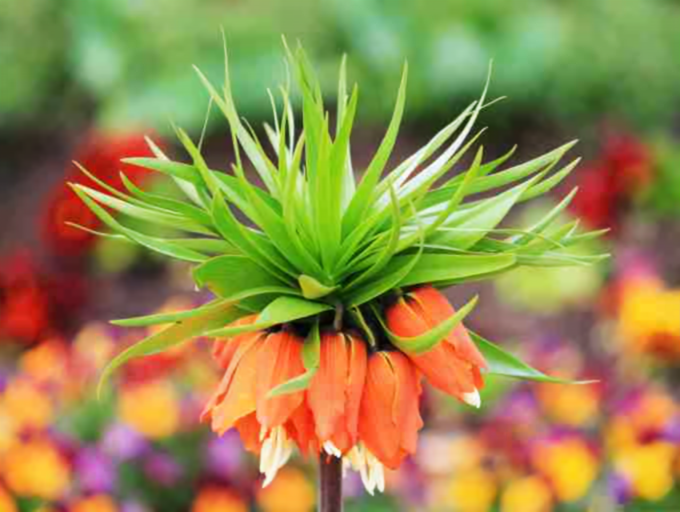

In [86]:
pred_img = bf.filter(img_low, img_low, 50); pred_img

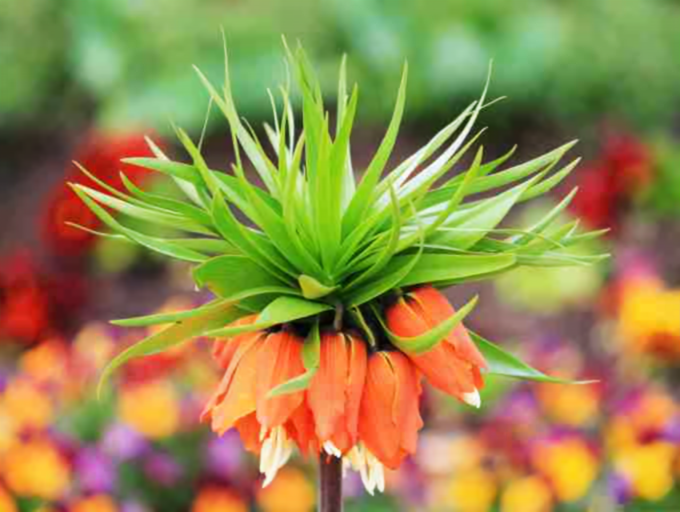

In [87]:
pred_img